In [328]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import time
import datetime

In [339]:
# hyperparameters
batch_size = 64 
block_size = 256 # spatial extent of the model for its context
max_iters = 5000 # number of training iterations
eval_interval = 500 # frequency of printing training stats
learning_rate = 3e-4
device = torch.device('mps')
eval_iters = 200 # number of iterations to evaluate the model
n_embd = 384
n_layers = 6
dropout = 0.2
n_head = 6
data_filepath = 'commedia.txt'
train_val_split = 0.95

In [340]:

# Load data
with open(data_filepath, 'r', encoding='utf-8') as f:
    text = f.read()

chars = sorted(list(set(text)))
vocab_size = len(chars)
stoi = {ch: i for i, ch in enumerate(chars)} # string to int
itos = {i: ch for i, ch in enumerate(chars)} # int to string
def encode(s): return [stoi[ch] for ch in s]
def decode(l): return ''.join([itos[i] for i in l])

# Split in to train anv validation
data = torch.tensor(encode(text), dtype=torch.long)
n = int(train_val_split * len(data))
train_data = data[:n]
val_data = data[n:]
print(f' - Length of train data: {len(train_data)}')
print(f' - Length of val data: {len(val_data)}')

def get_batch(split, batch_size, block_size):
    """
    Get a batch of data for training or validation.

    Parameters:
    split (str): The split to get the data from. Can be 'train' or 'val'.
    batch_size (int): The batch size.
    block_size (int): The sequence length.

    Returns:
    torch.Tensor, torch.Tensor: The input data (x) and target data (y) as tensors.
    """

    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i: i + block_size] for i in ix])
    y = torch.stack([data[i + 1: i + block_size + 1] for i in ix])
    return x, y



 - Length of train data: 170866
 - Length of val data: 8993


In [341]:

class Transformer(nn.Module): 
    ''' A transformer language model. Parameters are defined in the hyperparameters section and do not need to be passed in.
    The class has two methods: forward and generate. Forward is used for training and generate is used for sampling.
    In the forward method, the input is a batch of sequences of tokens, and optionally a batch of target sequences of tokens.'''
    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(
            *[Block(n_embd, n_layers) for _ in range(n_layers)]
        )
        self.final_ln = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        ''' idx is a batch of sequences of tokens. targets is a batch of target sequences of tokens. If targets is None, then the loss is not calculated.'''
        B, T = idx.shape
        # idx and targets are both (B,T) tensors. where B is batch size and T is the number of tokens in each sequence (block_size*batch_size)

        tok_emb = self.token_embedding_table(idx)  # (B,T,C)
        pos_emb = self.position_embedding_table(
            torch.arange(T, device=device))  # (T,C)
        x = tok_emb + pos_emb  # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.final_ln(x) # (B,T,C)
        logits = self.lm_head(x)  # (B,T,V)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        ''' idx is a batch of sequences of tokens. max_new_tokens is the maximum number of tokens to generate.'''
        for _ in range(max_new_tokens):
            # crop idx
            idx_cond = idx[:, -block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=-1)
        return idx


class Head(nn.Module):
    '''a single self attention head'''

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(
            torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)  # (B,T,C)
        q = self.query(x)  # (B,T,C)
        wei = q @ k.transpose(-2, -1) * (C ** -0.5)  # (B,T,T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)  # (B,T,T)
        wei = self.dropout(wei)
        v = self.value(x)  # (B,T,C)
        out = wei @ v  # (B,T,C)
        return out


class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(n_heads)])
        # Q. what is proj an abbreviation for? A. projection Q. What is meant by projection? A. I think it means that the output is the same size as the input.3
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([head(x) for head in self.heads], dim=-1)  # (B,T,C)
        out = self.proj(out)
        out = self.dropout(out)
        return out


class FeedForward(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)


class Block(nn.Module):
    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x


class LayerNorm(nn.Module):

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

    def __call__(self, x):
        # calculate the forward pass

        xmean = x.mean(1, keepdim=True)  # batch mean
        xvar = x.var(1, keepdim=True)  # batch variance

        # normalize to unit variance
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

In [342]:
m = Transformer().to(device)
print(f'Model is running on {device}')
print(f'Number of parameters: {sum(p.numel() for p in m.parameters())}')

Model is running on mps
Number of parameters: 10785084


In [306]:

# Training loop
optimizer = torch.optim.Adam(m.parameters(), lr=learning_rate) 
lossi = [] # loss history
start_time = time.time() 

for steps in range(max_iters):
    xb, yb = get_batch('train')
    xb, yb = xb.to(device), yb.to(device)
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    lossi.append(loss.log10().item())
    
    if steps % eval_interval == 0 or steps == max_iters - 1:
        current_time = time.time() - start_time
        formatted_time = str(datetime.timedelta(seconds=current_time))
        print(f'step: {steps}, loss: {loss.item()}, time taken: {formatted_time}')

        # Estimate remaining time
        steps_remaining = max_iters - steps
        time_per_step = current_time / (steps + 1)  # Avoid division by zero
        remaining_time = datetime.timedelta(seconds=steps_remaining * time_per_step)
        print(f'estimated time remaining: {remaining_time}')

# Print the total training time
total_time = time.time() - start_time
formatted_total_time = str(datetime.timedelta(seconds=total_time))
print(f'Total training time: {formatted_total_time}')


step: 0, loss: 0.27749037742614746, time taken: 0:00:51.520613
estimated time remaining: 2 days, 23:33:23.065968
step: 500, loss: 0.23571012914180756, time taken: 0:11:33.767167
estimated time remaining: 1:43:51.441621
step: 1000, loss: 0.19895993173122406, time taken: 0:22:12.680410
estimated time remaining: 1:28:45.396244
step: 1500, loss: 0.18962806463241577, time taken: 0:32:54.211022
estimated time remaining: 1:16:43.423436
step: 2000, loss: 0.1612018197774887, time taken: 0:43:52.869746
estimated time remaining: 1:05:47.330953
step: 2500, loss: 0.16034285724163055, time taken: 0:54:42.986093
estimated time remaining: 0:54:41.673424
step: 3000, loss: 0.15108683705329895, time taken: 1:05:47.757806
estimated time remaining: 0:43:50.961550
step: 3500, loss: 0.1387234479188919, time taken: 1:16:47.657694
estimated time remaining: 0:32:54.146398
step: 4000, loss: 0.13468334078788757, time taken: 1:27:34.622010
estimated time remaining: 0:21:53.327171
step: 4500, loss: 0.12445821613073

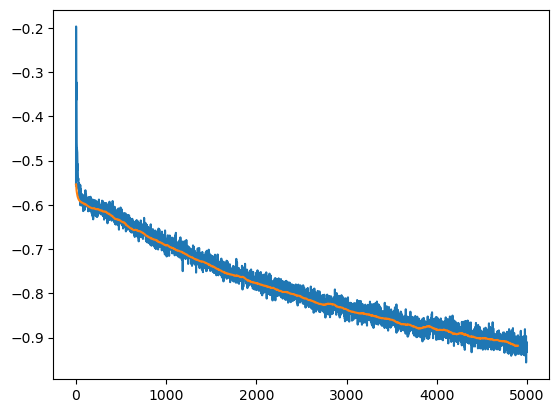

In [308]:
plt.plot(lossi)
lossi_means = [sum(lossi[i:i+100])/100 for i in range(len(lossi)-100)]
plt.plot(lossi_means)
plt.show()

In [309]:
# Evaluation loop over validation set

with torch.no_grad():
    total_loss = 0
    for steps in range(eval_iters):
        xb, yb = get_batch('val')
        xb, yb = xb.to(device), yb.to(device)
        logits, loss = m(xb, yb)
        total_loss += loss.item()
    print(f'validation loss: {total_loss/eval_iters}')



KeyboardInterrupt: 

In [325]:
# Generate from the model, printing the output as it goes
new_chars = 10000
idx = torch.zeros((1, 1), dtype=torch.long).to(device)

for _ in range(new_chars):
    output = m.generate(idx, 1)[0].tolist()
    decoded_output = decode(output)
    print(decoded_output[-1], end='')
    idx = torch.tensor([output], dtype=torch.long).to(device)


che la prima avea vea enaea luca:
"O virte poeta voler cio` che s'altra,
se 'l vene ogne simile anzia la coda?

Per che 'l duca mio a guardar piu` di morti,

KeyboardInterrupt: 

In [260]:
# # Time printing 100 characters on mps and cpu
# # MPS
# import time
# t0 = time.time()
# new_chars = 100
# idx = torch.zeros((1, 1), dtype=torch.long).to(device)

# for _ in range(new_chars):
#     output = m.generate(idx, 1)[0].tolist()
#     decoded_output = decode(output)
#     print(decoded_output[-1], end='')
#     idx = torch.tensor([output], dtype=torch.long).to(device)
# t1 = time.time()
# print('\ntime taken: ', t1-t0)

# # CPU
# device = torch.device('mps')
# m = Transformer()
# # Load the saved model
# m.load_state_dict(torch.load('model_finalvideo_shakespeare.pt', map_location='cpu'))
# m.to(device)
# import time
# t0 = time.time()
# new_chars = 100
# idx = torch.zeros((1, 1), dtype=torch.long).to('mps')

# for _ in range(new_chars):
#     output = m.generate(idx, 1)[0].tolist()
#     decoded_output = decode(output)
#     print(decoded_output[-1], end='')
#     idx = torch.tensor([output], dtype=torch.long).to(device)

# t1 = time.time()
# print('\ntime taken: ', t1-t0)



In [311]:
# We will do the following: generate 500 tokens, then go through the generate text and take every three word group, and see if we can find it in the original text
idx = torch.zeros((1, 1), dtype=torch.long).to(device)
test_output = decode(m.generate(idx, 5000)[0].tolist())

In [323]:
with open('commedia.txt', 'r', encoding='utf-8') as f:
    text = f.read()
def find_combinations(test_output, n):
    word_list = test_output.split()

    found_counter = 0
    for i in range(len(word_list)-n+1):
        search = " ".join(word_list[i:i+n])
        if search in text:
            print(f'"{search}" found in text')
            found_counter += 1

    print(f'{found_counter} examples found out of {len(word_list)-n+1}')
find_combinations(test_output, 3)


"per che la" found in text
"ond' io mi" found in text
"in giuso e`" found in text
"giuso e` tutto" found in text
"e` tutto ferro" found in text
"tutto ferro eletto," found in text
"salvo che 'l" found in text
"che 'l destro" found in text
"'l destro piede" found in text
"destro piede e`" found in text
"quel che tu" found in text
"che tu vuoli";" found in text
"i per la" found in text
"per la gran" found in text
"Allor lo presi" found in text
"a me che" found in text
"il primo canto" found in text
"la colpa che" found in text
"che 'l morde" found in text
"di qua, di" found in text
"qua, di la`," found in text
"di la`, e" found in text
"la`, e poi" found in text
"forza ne la" found in text
"la terra che" found in text
"terra che fe'" found in text
"che fe' gia`" found in text
"disse 'l mio" found in text
"'l mio duca," found in text
"che non li" found in text
"non li ha," found in text
"fe' gia` la" found in text
"ne la sua" found in text
"e io e" found in text
"su per l'ombre" found in 